In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

## Define Classes

In [3]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [4]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)

In [5]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

## Load Data

In [6]:
data = ETL('^NSEI')

## 2. Implementing an LSTM baseline

In [11]:
def build_lstm(etl: ETL, epochs=25, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits our LSTM baseline model.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
  model = Sequential()
  model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
  model.add(LSTM(128, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs))
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
  print('fitting model...')
  start = time.time()
  history = model.fit(etl.X_train, etl.y_train, batch_size=batch_size, epochs=epochs, validation_data=(etl.X_test, etl.y_test), verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return model, history

In [12]:
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/25


/opt/anaconda3/envs/Conda_310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 42401024.0000 - mae: 5287.8096 - mape: 67.0488 - val_loss: 177353.7500 - val_mae: 337.0265 - val_mape: 1.7643
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 49900.0703 - mae: 158.9817 - mape: 2.3195 - val_loss: 158732.0000 - val_mae: 309.2182 - val_mape: 1.6263
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 51963.2578 - mae: 161.9083 - mape: 2.3246 - val_loss: 152294.2344 - val_mae: 315.3262 - val_mape: 1.6517
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55480.1172 - mae: 159.6795 - mape: 2.2905 - val_loss: 145902.7812 - val_mae: 303.9930 - val_mape: 1.5959
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 51228.1289 - mae: 160.5089 - mape: 2.3332 - val_loss: 142909.2031 - val_mae: 300.4581 - val_mape: 1.5777
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 53795.0625 - mae: 159.7611 - mape: 2.3435 - val_loss: 144320.9688 - val_mae: 294.9718 - val_mape: 1.5538
Epoch 7/25
105/1

In [13]:
baseline_model = baseline[0]
history = baseline[1]

In [14]:
baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,549 (2.34 MB)

 Trainable params: 204,849 (800.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 409,700 (1.56 MB)

## 3. Implementing a Transformer

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [16]:
transformer = build_transfromer(head_size=128, 
                                num_heads=4, 
                                ff_dim=2, 
                                num_trans_blocks=4, 
                                mlp_units=[256], 
                                mlp_dropout=0.10, 
                                dropout=0.10, 
                                attention_axes=1)

In [17]:
transformer.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 1)      │          2 │ input_layer_3[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 1)      │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 2)      │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 2)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 1)      │          3 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 1)      │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 1)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 2)      │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 5, 2)      │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5, 1)      │          3 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 1)      │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,205 (67.21 KB)

 Trainable params: 17,205 (67.21 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist


In [19]:
hist = fit_transformer(transformer)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 18443694.0000 - mae: 2956.5830 - mape: 38.1030
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 468298.5312 - mae: 510.2628 - mape: 6.6632
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 455597.1562 - mae: 501.9914 - mape: 6.5637
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 371632.2188 - mae: 456.1438 - mape: 6.0228
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 349547.8438 - mae: 440.0022 - mape: 5.7363
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 302777.7188 - mae: 411.5008 - mape: 5.5219
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 296112.6562 - mae: 403.1887 - mape: 5.2969
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 272934.0312 - mae: 393.3826 - mape: 5.2022
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 252658.2188 - mae: 372.7494 - mape: 4.9397
Epoch 10/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 241516.4

### Inference on our Models

In [ ]:
start = time.time()
baseline_preds = PredictAndForecast(baseline_model, data.train, data.test)
print(time.time() - start)

6.135110855102539


In [ ]:
start = time.time()
transformer_preds = PredictAndForecast(transformer, data.train, data.test)
print(time.time() - start)

6.437600135803223


# 4. Evaluating on test set

In [ ]:
baseline_evals = Evaluate(data.test, baseline_preds.predictions)
transformer_evals = Evaluate(data.test, transformer_preds.predictions)

In [ ]:
baseline_evals.mape, transformer_evals.mape

(0.014950225556604975, 0.0145524123638695)

In [ ]:
baseline_evals.var_ratio, transformer_evals.var_ratio

(0.005692354637686359, 0.013790551332605538)

# 5. Visualizing

In [ ]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='AAPL stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

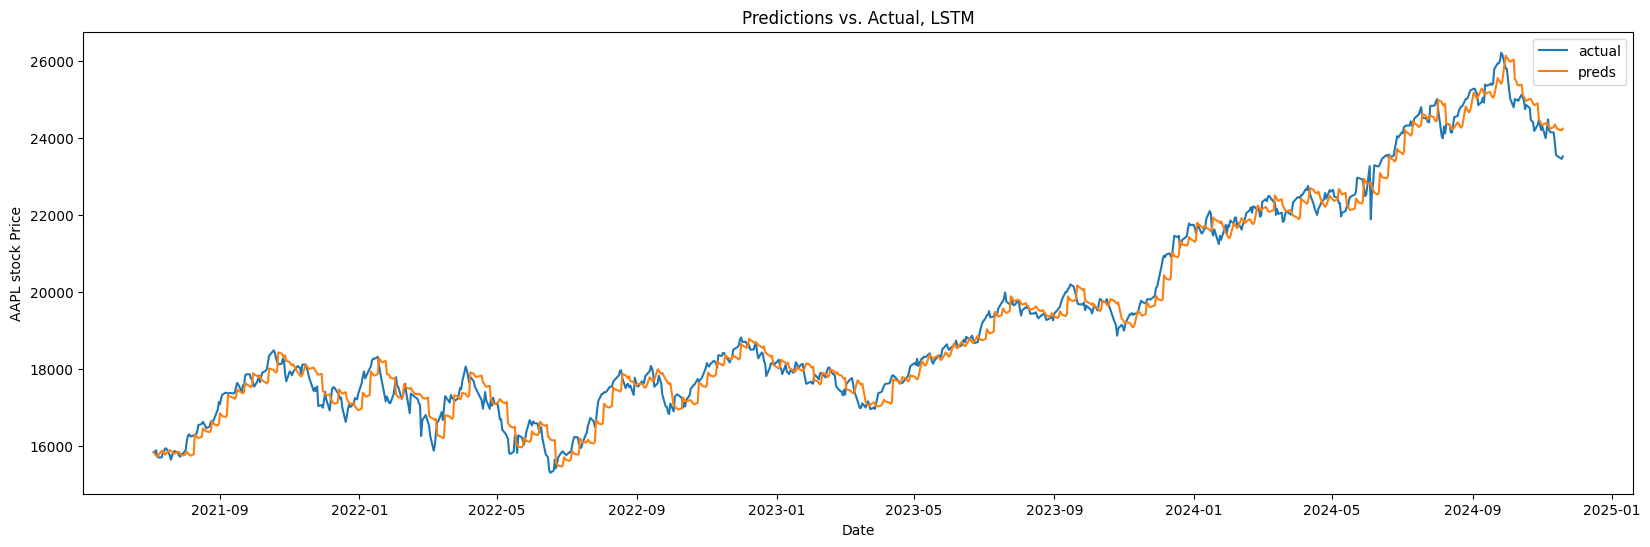

In [ ]:
plot_results(data.test, baseline_preds.predictions, data.df, title_suffix='LSTM')

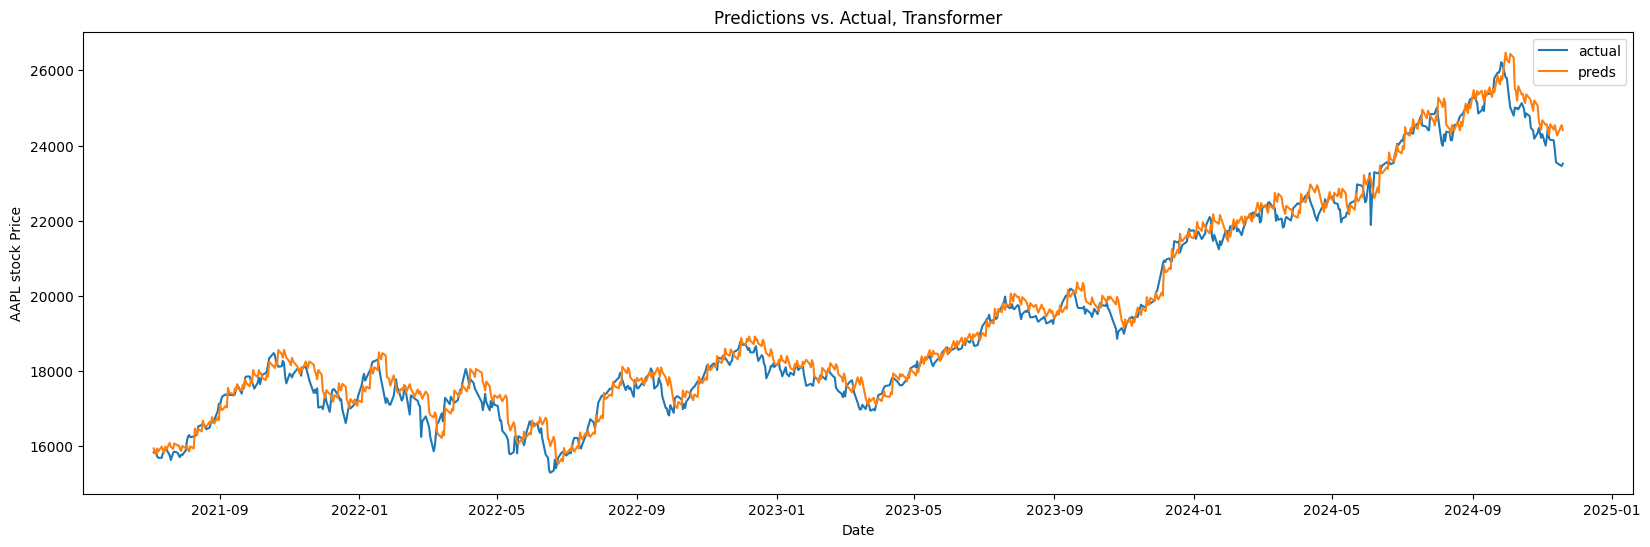

In [ ]:
plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')